In [10]:
import pandas as pd
import numpy as np
import glob
from sklearn.cluster import KMeans
from shapely.geometry import Point
import matplotlib.pyplot as plt
import os

### Function defns

In [11]:
# compute_cluster_radii helper function
# computes distance between two coordinates
def single_dist(coord1,coord2):
    dist = Point(coord1).distance(Point(coord2))
    return(dist)

# structure_assigner helper function
# input: kmeans cluster centers and tuples eroded points and which cluster they each belong to
# returns radius of each cluster
def compute_cluster_radii(cluster_centers, eroded):
    radii = []
    clusters = np.unique(eroded['cluster'])
    
    for i,cluster in enumerate(clusters):
        center = cluster_centers[i]
        cluster = eroded[eroded['cluster']==cluster].copy()
        cluster_coords = np.array(cluster[['x','y']])
        d_to_center = [single_dist(c,center) for c in cluster_coords]
        radii.append(max(d_to_center))   
    
    return(radii)

def is_in_circle(coord,center,r):
    return(single_dist(coord,center) < r)

# input: centers of curated podocyte clusters, curated podocyte beads, other celltypes to be added
# assigns all other coordinates assigned cell types other than marker to structure components
# returns data frame with all coords within structure, their cluster assignments, and cell type assignments
def assign_other_celltypes(cluster_centers, eroded, other, cell_type):
    radii = compute_cluster_radii(cluster_centers,eroded)
    other = other[other['cell_type']==cell_type].copy()
    other_coords = np.array(other[['x','y']])
    other_barcodes = [x[0] for x in np.array(other[['barcode']])]
    n_clusters = len(cluster_centers)
    result = []
    for i in range(len(other_coords)):
        for j in range(n_clusters):
            if(is_in_circle(other_coords[i],cluster_centers[j],radii[j])):
                to_append = [other_barcodes[i],j]
                result.append(to_append)
                break
    return(result)

### File input

In [26]:
# input_path is path to data matrix with beads x features for all curated podocytes
# features = {'barcode','x','y'} 
input_path = '/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713333_BeadLocationsAll_eroded.csv'
allcells_dat=pd.read_csv(input_path,index_col=0)

# select podocyte and non-podocyte cells
podo_dat = allcells_dat[allcells_dat ['cell_type'] == 'Podocyte' ]
podo_dat = podo_dat.reset_index()
podo_dat = podo_dat.drop(columns={'index'})
other_cells_dat = allcells_dat[ allcells_dat ['cell_type'] != 'Podocyte' ]
other_cells_dat = other_cells_dat.reset_index()
other_cells_dat = other_cells_dat.drop(columns={'index'})

### Analysis

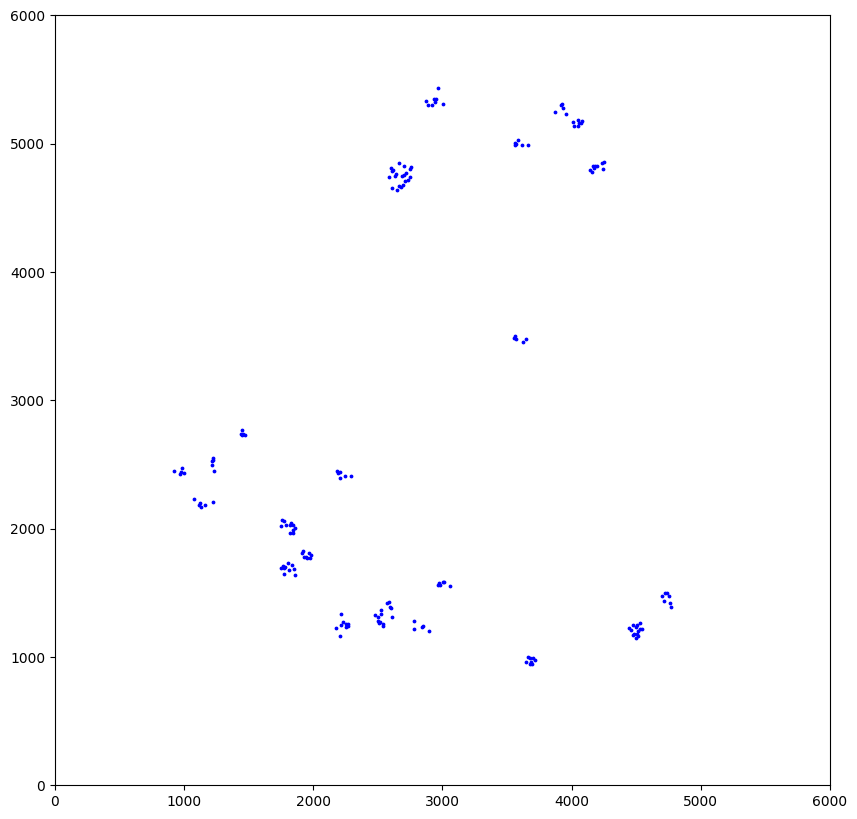

In [9]:
### visualize podocytes to determine number of glomeruli (n_clusters param)
plt.figure(figsize=(10,10))
plt.scatter(podo_dat['x'],podo_dat['y'],s=3,c='b')
plt.xlim(0,6000)
plt.ylim(0,6000)
plt.show()

In [27]:
### find cluster centers of curated podocyte markers
# set n_clusters to number of podocyte clusters in array
n_clusters=23
coords = np.array(podo_dat[['x','y']])
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(coords)
podo_cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_
podo_dat['cluster'] = labels

/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
### find mesangial cells in glomerular areas
mesangial_in_glom = assign_other_celltypes(podo_cluster_centers,podo_dat,other_cells_dat,'MC')
mesangial_in_glom = pd.DataFrame(mesangial_in_glom)
mesangial_in_glom = mesangial_in_glom.rename(columns={0:'barcode',1:'cluster'})
mesangial_in_glom = other_cells_dat.merge(mesangial_in_glom,on='barcode')

### find endothelial cells in glomerular areas
endothelial_in_glom = assign_other_celltypes(podo_cluster_centers,podo_dat,other_cells_dat,'EC')
endothelial_in_glom = pd.DataFrame(endothelial_in_glom)
endothelial_in_glom = endothelial_in_glom.rename(columns={0:'barcode',1:'cluster'})
endothelial_in_glom = other_cells_dat.merge(endothelial_in_glom,on='barcode')

### find old podo cells in glomerular areas
oldP_in_glom = assign_other_celltypes(podo_cluster_centers,podo_dat,other_cells_dat,'oldPodo')
oldP_in_glom = pd.DataFrame(oldP_in_glom)
oldP_in_glom = oldP_in_glom.rename(columns={0:'barcode',1:'cluster'})
oldP_in_glom = other_cells_dat.merge(oldP_in_glom,on='barcode')

podo_dat['cell_type']=['Podocyte']*podo_dat.shape[0]
podo_dat = podo_dat[['barcode','x','y','cell_type','cluster']]

final = pd.concat([podo_dat,mesangial_in_glom,endothelial_in_glom,oldP_in_glom])
final = final.reset_index()
final = final.drop(columns={'index'})

In [17]:
# out_path is path to output file
out_path = '/home/tim_nevelsk/PROJECTS/PODOCYTE/DiseaseScore/Development_Validation/Spatial.trnscrptm/GSE190094/GSM5713333.all_glomerular_cells.csv'
final.to_csv(out_path)

### Plot filtered podocytes for a list of samples

In [39]:
# directory with coordinate files
input_dir = '/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/test8/TimsPodoAnnot/*KNN_eroded.csv'
# Turn interactive plotting off
plt.ioff()

for file in glob.glob(input_dir):

    # read in coordinate file
    allcells_dat=pd.read_csv(file,index_col=0)

    # select podocyte and non-podocyte cells
    podo_dat = allcells_dat[allcells_dat ['cell_type'] == 'Podocyte' ]
    podo_dat = podo_dat.reset_index()
    podo_dat = podo_dat.drop(columns={'index'})
    other_cells_dat = allcells_dat[ allcells_dat ['cell_type'] != 'Podocyte' ]
    other_cells_dat = other_cells_dat.reset_index()
    other_cells_dat = other_cells_dat.drop(columns={'index'})

    ### visualize podocytes to determine number of glomeruli (n_clusters param)
    plt.figure(figsize=(10,10))
    plt.scatter(podo_dat['x'],podo_dat['y'],s=3,c='b')
    plt.xlim(0,6000)
    plt.ylim(0,6000)
    plt.savefig( file.replace("KNN_eroded","podo_image").replace("csv","png"))
    plt.close()

### Add other ctypes to gloms for a list of files

In [36]:
# directory with coordinate files
# input_dir = '/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/*All_eroded.csv'
input_dir = '/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/*All_eroded.csv'

# list of files
input_files = glob.glob(input_dir)
input_files = sorted(input_files)

# list of K parameters for each sample
# K = [22,11,14,15,7,18,17,19] for og podo annotations
# K = [23,12,23,25,16,22,17,32] # GSM5713333,42,71,75,76,78,48,69
K = [23,15,6,17,8,11,10,6,10,18,34,18,15,19,22,29,16,7,25,11,18,9,15,16,23,20,21,21,21] # GSM5713333,42,75,76,78,48,69, removed sample 71
# K = [9,15,16,23,20,21,21,21] # GSM5713333,42,75,76,78,48,69, removed sample 71


for ii in range(len(input_files)) :

    print(ii)

    file_in = input_files[ii]
    print(file_in)
    # read in coordinate file
    allcells_dat=pd.read_csv(file_in,index_col=0)

    # select podocyte and non-podocyte cells
    podo_dat = allcells_dat[allcells_dat ['cell_type'] == 'Podocyte' ]
    podo_dat = podo_dat.reset_index()
    podo_dat = podo_dat.drop(columns={'index'})
    other_cells_dat = allcells_dat[ allcells_dat ['cell_type'] != 'Podocyte' ]
    other_cells_dat = other_cells_dat.reset_index()
    other_cells_dat = other_cells_dat.drop(columns={'index'})
    
    ### find cluster centers of curated podocyte markers
    # set n_clusters to number of podocyte clusters in array
    n_clusters=K[ii]
    print(n_clusters)

    coords = np.array(podo_dat[['x','y']])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42 ).fit(coords)
    podo_cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    podo_dat['cluster'] = labels

    ### find mesangial cells in glomerular areas
    mesangial_in_glom = assign_other_celltypes(podo_cluster_centers,podo_dat,other_cells_dat,'MC')
    mesangial_in_glom = pd.DataFrame(mesangial_in_glom)
    mesangial_in_glom = mesangial_in_glom.rename(columns={0:'barcode',1:'cluster'})
    mesangial_in_glom = other_cells_dat.merge(mesangial_in_glom,on='barcode')
    
    ### find endothelial cells in glomerular areas
    endothelial_in_glom = assign_other_celltypes(podo_cluster_centers,podo_dat,other_cells_dat,'EC')
    endothelial_in_glom = pd.DataFrame(endothelial_in_glom)
    endothelial_in_glom = endothelial_in_glom.rename(columns={0:'barcode',1:'cluster'})
    endothelial_in_glom = other_cells_dat.merge(endothelial_in_glom,on='barcode')

    ### find old podo cells in glomerular areas
    oldP_in_glom = assign_other_celltypes(podo_cluster_centers,podo_dat,other_cells_dat,'oldPodo')
    oldP_in_glom = pd.DataFrame(oldP_in_glom)
    oldP_in_glom = oldP_in_glom.rename(columns={0:'barcode',1:'cluster'})
    oldP_in_glom = other_cells_dat.merge(oldP_in_glom,on='barcode')

    
    podo_dat['cell_type']=['Podocyte']*podo_dat.shape[0]
    podo_dat = podo_dat[['barcode','x','y','cell_type','cluster']]
    
    final = pd.concat([podo_dat,mesangial_in_glom,endothelial_in_glom,oldP_in_glom])
    final = final.reset_index()
    final = final.drop(columns={'index'})

    # out_path is path to output file
    file_out = file_in.replace("_eroded.csv","glom_annot.csv")

    final.to_csv(file_out)

0
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713372_BeadLocationsAll_eroded.csv
9


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713373_BeadLocationsAll_eroded.csv
15


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713374_BeadLocationsAll_eroded.csv
16


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713375_BeadLocationsAll_eroded.csv
23


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713376_BeadLocationsAll_eroded.csv
20


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713377_BeadLocationsAll_eroded.csv
21


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713378_BeadLocationsAll_eroded.csv
21


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/test/GSM5713380_BeadLocationsAll_eroded.csv
21


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Calculate glom radius

In [40]:
# directory with coordinate files
input_dir = '/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/*All_eroded.csv'

# list of files
input_files = glob.glob(input_dir)
input_files = sorted(input_files)

# list of K parameters for each sample
# K = [22,11,14,15,7,18,17,19] for og podo annotations
# K = [23,12,23,25,16,22,17,32] # GSM5713333,42,71,75,76,78,48,69
# K = [23,12,25,16,22,17,32] # GSM5713333,42,75,76,78,48,69, removed sample 71
K = [23,15,6,17,8,11,10,6,10,18,34,18,15,19,22,29,16,7,25,11,18,9,15,16,23,20,21,21,21] # GSM5713333,42,75,76,78,48,69, removed sample 71


for ii in range(len(input_files)) :

    print(ii)

    file_in = input_files[ii]
    print(file_in)
    # read in coordinate file
    allcells_dat=pd.read_csv(file_in,index_col=0)

    # select podocyte and non-podocyte cells
    podo_dat = allcells_dat[allcells_dat ['cell_type'] == 'Podocyte' ]
    podo_dat = podo_dat.reset_index()
    podo_dat = podo_dat.drop(columns={'index'})
    other_cells_dat = allcells_dat[ allcells_dat ['cell_type'] != 'Podocyte' ]
    other_cells_dat = other_cells_dat.reset_index()
    other_cells_dat = other_cells_dat.drop(columns={'index'})
    
    ### find cluster centers of curated podocyte markers
    # set n_clusters to number of podocyte clusters in array
    n_clusters=K[ii]
    print(n_clusters)

    coords = np.array(podo_dat[['x','y']])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42 ).fit(coords)
    podo_cluster_centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    podo_dat['cluster'] = labels
   
    #  convert to df   
    podo_cluster_centers_df=pd.DataFrame(podo_cluster_centers,columns= ['x', 'y'])

    
    ## compute cluster radii 
    cl_radii = compute_cluster_radii( podo_cluster_centers , podo_dat)
    #  convert to df   
    cl_radii_df=pd.DataFrame({'radii':cl_radii})

    # merge 
    glom_coord_df = pd.concat( [cl_radii_df, podo_cluster_centers_df], axis=1)
    
    # out_path is path to output file
    file_out = file_in.replace("All_eroded.csv","_glom_coord.csv")
    glom_coord_df.to_csv(file_out)

0
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713333_BeadLocationsAll_eroded.csv
23


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713342_BeadLocationsAll_eroded.csv
15


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


2
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713347_BeadLocationsAll_eroded.csv
6
3
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713348_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713349_BeadLocationsAll_eroded.csv
8
5
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713350_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


11


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713352_BeadLocationsAll_eroded.csv
10


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713353_BeadLocationsAll_eroded.csv
6
8
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713356_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713357_BeadLocationsAll_eroded.csv
18


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713361_BeadLocationsAll_eroded.csv
34


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


11
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713362_BeadLocationsAll_eroded.csv
18


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713363_BeadLocationsAll_eroded.csv
15
13
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713364_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


14
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713365_BeadLocationsAll_eroded.csv
22


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713366_BeadLocationsAll_eroded.csv
29


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713367_BeadLocationsAll_eroded.csv
16


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713368_BeadLocationsAll_eroded.csv
7


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713369_BeadLocationsAll_eroded.csv
25


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713370_BeadLocationsAll_eroded.csv
11
20
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713371_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


21
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713372_BeadLocationsAll_eroded.csv
9
22
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713373_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15
23
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713374_BeadLocationsAll_eroded.csv
16


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


24
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713375_BeadLocationsAll_eroded.csv
23


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


25
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713376_BeadLocationsAll_eroded.csv
20


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


26
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713377_BeadLocationsAll_eroded.csv
21


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


27
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713378_BeadLocationsAll_eroded.csv
21
28
/media/tim_nevelsk/WD_tim/PROJECTS/PODOCYTES/Spatial.Transcr/GSE190094_RAW/BTBR/podoClust/BeadLocationsPodoTim/GSM5713380_BeadLocationsAll_eroded.csv


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


21


/home/tim_nevelsk/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
